In [1]:
import os
import time
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix, Precision, Recall
from ignite.contrib.metrics import ROC_AUC
from ignite.handlers import ModelCheckpoint, EarlyStopping, Timer

try:
    from tensorboardX import SummaryWriter
except ImportError:
    try:
        from torch.utils.tensorboard import SummaryWriter
    except ImportError:
        raise RuntimeError(
            "This module requires either tensorboardX or torch >= 1.2.0. "
            "You may install tensorboardX with command: \n pip install tensorboardX \n"
            "or upgrade PyTorch using your package manager of choice (pip or conda)."
        )

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return F.log_softmax(x,dim=1)

In [3]:
def create_summary_writer(model, data_loader, log_dir):
    writer = SummaryWriter(log_dir=log_dir)
    data_loader_iter = iter(data_loader)
    x, y = next(data_loader_iter)
    try:
        writer.add_graph(model, x)
    except Exception as e:
        print("Failed to save model graph: {}".format(e))
    return writer

In [4]:
def get_next_run_name(log_dir):
    if not os.path.isdir(log_dir):
        return os.path.join(log_dir, 'run_0')
    else:
        runs = [int(d[4:]) for d in next(os.walk(log_dir))[1] if d[:3] == 'run']
        return os.path.join(log_dir, 'run_' + str(max(runs) + 1))

In [5]:
def activated_output_transform(output):
    y_pred, y = output
    y_pred = torch.sigmoid(y_pred)
    return y_pred, y

In [6]:
def save_cm(cm, filename='', classes=[]):
    fig = plt.figure(figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(cm, cmap='Oranges')
    
    if len(classes) == 0:
        classes = [str(c) for c in range(len(cm))]
    tick_marks = np.arange(len(classes))
    
    ax.set_xlabel('Predicted', fontsize=7)
    ax.set_xticks(tick_marks)
    c = ax.set_xticklabels(classes, fontsize=7, rotation=-90,  ha='center')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True Label', fontsize=7)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=7, va ='center')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd') if cm[i,j]!=0 else '.', horizontalalignment="center", fontsize=6, verticalalignment='center', color="black")
    fig.set_tight_layout(True)
    plt.savefig(os.path.join(filename, 'confusion_matrix.jpg'))
    plt.close()

In [15]:
def get_data_loaders(train_batch_size, val_batch_size, train_hold_ratio=0.5):
    dataset_name = 'MNIST'
    
    train_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
    
    test_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
    
    train_dataset = datasets.FashionMNIST('./data', download=True, train=True, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    
    test_dataset = datasets.FashionMNIST('./data', download=True, train=False, transform=test_transform)
    
    test_indices = np.arange(len(test_dataset))
    divide_point = int(len(test_dataset) * train_hold_ratio)
    
    validation_dataset = Subset(train_dataset, indices=np.random.permutation(test_indices)[:divide_point])
    validation_loader = DataLoader(validation_dataset, batch_size=val_batch_size, shuffle=True)
    
    holdout_dataset = Subset(train_dataset, indices=np.random.permutation(test_indices)[divide_point:])
    holdout_loader = DataLoader(holdout_dataset, batch_size=val_batch_size, shuffle=True)
    
    return train_loader, validation_loader, holdout_loader, dataset_name

In [35]:
def run(params):
    train_loader, val_loader, holdout_loader, dataset_name = get_data_loaders(params['train_batch_size'], params['val_batch_size'])
    model_dir = os.path.join(params['log_dir'], dataset_name)
    run_dir = get_next_run_name(model_dir)
    
    model = params['model']
    
    writer = create_summary_writer(model, train_loader, run_dir)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"

    optimizer = params['optimizer'](model.parameters(), lr=params['lr'])
    criterion = params['criterion']
    scheduler = ReduceLROnPlateau(optimizer, patience=params['lr_patience'], factor=params['lr_factor'], min_lr=params['min_lr'])
    
    model_name = (
        params['model_name'] + 
        '_lr:' + str(params['lr']) +
        '_' + str(optimizer).split(' ')[0] +
        '_' + str(criterion).split('.')[-1].split("'")[0][:-2]
    )
    
    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    train_timer = Timer(average=True)
    train_timer.attach(trainer, start=Events.EPOCH_STARTED, 
                       resume=Events.EPOCH_STARTED, 
                       pause=Events.EPOCH_COMPLETED, 
                       step=Events.EPOCH_STARTED)
    
    train_evaluator = create_supervised_evaluator(
        model, 
        metrics=
        {
            "accuracy": Accuracy(), 
            "nll": Loss(F.nll_loss),
        },
        device=device
    )
    
    val_evaluator = create_supervised_evaluator(
        model, 
        metrics=
        {
            "accuracy": Accuracy(), 
            "nll": Loss(F.nll_loss),
            "precision": Precision(),
            "recall": Recall(),
            "conf_matrix": ConfusionMatrix(10),
        },
        device=device
    )
    
    def score_function(engine):
        val_loss = engine.state.metrics['nll']
        return -val_loss
    
    if params['early_stopping']:
        handler = EarlyStopping(patience=params['early_stopping_patience'], score_function=score_function, trainer=trainer)
        val_evaluator.add_event_handler(Events.COMPLETED, handler)
    
    checkpointer = ModelCheckpoint(os.path.join(model_dir,'saved_models'), dataset_name, n_saved=3, create_dir=True, save_as_state_dict=True, require_empty=False)
    trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {model_name: model})
    
    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']

    @trainer.on(Events.ITERATION_COMPLETED(every=params['log_interval']))
    def log_training_loss(engine):
        if params['tensorboard']:
            writer.add_scalar("training/batch_loss", engine.state.output, engine.state.iteration)
        
        if params['verbose']:
            print(
                "Epoch[{}] Iteration[{}/{}] Loss: {:.2f}"
                "".format(engine.state.epoch, engine.state.iteration, len(train_loader), engine.state.output)
            )

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        metrics = train_evaluator.state.metrics
        avg_accuracy = metrics["accuracy"]
        avg_nll = metrics["nll"]
        
        if params['tensorboard']:
            writer.add_scalar("training/epoch_loss", avg_nll, engine.state.epoch)
            writer.add_scalar("training/epoch_accuracy", avg_accuracy, engine.state.epoch)
        
        if params['verbose']:
            print(
                "Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_nll
                )
            )

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(engine):
        val_evaluator.run(val_loader)        
        metrics = val_evaluator.state.metrics
        accuracy = metrics["accuracy"]       
        precision = metrics["precision"]
        recall = metrics["recall"]
        
        nll = metrics["nll"] 
        if scheduler:
            scheduler.step(nll)
        
        save_cm(metrics["conf_matrix"] , filename=run_dir, classes=[])

        if params['tensorboard']:
            writer.add_scalar("valdation/epoch_loss", nll, engine.state.epoch)
            writer.add_scalar("valdation/epoch_accuracy", accuracy, engine.state.epoch)            
            writer.add_scalar("valdation/epoch_precision", precision.sum() / len(precision), engine.state.epoch)
            writer.add_scalar("valdation/epoch_recall", recall.sum() / len(recall), engine.state.epoch)
            
            writer.add_scalar("valdation/learning_rate", get_lr(optimizer), engine.state.epoch)
        
        if params['verbose']:
            print(
                "Validation Results - Epoch: {}  Accuracy: {:.2f}  loss: {:.2f}".format(
                    engine.state.epoch, accuracy, nll
                )
            )
    
    @trainer.on(Events.COMPLETED)
    def log_holdout(engine):
        val_evaluator.run(holdout_loader)
        metrics = val_evaluator.state.metrics
        accuracy = metrics["accuracy"]       
        precision = metrics["precision"]
        recall = metrics["recall"]

        save_cm(metrics["conf_matrix"], filename=run_dir, classes=[])
        
        print('Final accuracy: ', accuracy)
        print('Confusion matrix: ', metrics["conf_matrix"])
        print('Precision: ', precision)
        print('Recall: ', recall)
        
        total_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        runs_df = pd.DataFrame({
            'model_name': [params['model_name']],
            'dataset_name': [dataset_name],
            'optimizer': [str(optimizer).split(' ')[0]],
            'criterion': [str(criterion).split('.')[-1].split("'")[0][:-2]],
            'init_lr': [params['lr']],
            'lr_patience': [params['lr_patience']],
            'min_lr': [params['min_lr']],
            'accuracy': [accuracy],
            'precision': [(sum(precision) / len(precision)).item()],
            'recall': [(sum(recall) / len(recall)).item()],
            'train_time(epoch)': [train_timer.value()],
            'train_images': [len(train_loader) * params['train_batch_size']],
            'total_model_params': [total_model_params],
            'holdout_images': [len(holdout_loader) * params['val_batch_size']],
            'validation_images': [len(val_loader) * params['val_batch_size']],
        })
        
        if os.path.exists('runs.csv'):
            old_runs_df = pd.read_csv('runs.csv', index_col=0)
            runs_df = pd.concat([old_runs_df, runs_df], ignore_index=True)
            
        runs_df.to_csv('runs.csv')
        
    trainer.run(train_loader, max_epochs=params['epochs'])
    writer.close()    
    return model

In [20]:
params = {
    'train_batch_size': 64,
    'val_batch_size': 64,
    'epochs': 40,
    'lr': 1e-3,
    'verbose': False,
    'tensorboard': True,
    'log_interval': 100,
    'log_dir': './tensorboard_logs',
    'model_name': 'LeNet',
    'model': CNN(),
    'criterion': nn.NLLLoss(),
    'optimizer': optim.Adam,
    'early_stopping': True,
    'early_stopping_patience': 11,
    'lr_patience': 5,
    'lr_factor': 0.25,
    'min_lr': 1e-5,
    
}

Engine run is terminating due to exception: [Errno 2] No such file or directory: './tensorboard_logs/MNIST/run_10final/confusion_matrix.jpg'.


FileNotFoundError: [Errno 2] No such file or directory: './tensorboard_logs/MNIST/run_10final/confusion_matrix.jpg'

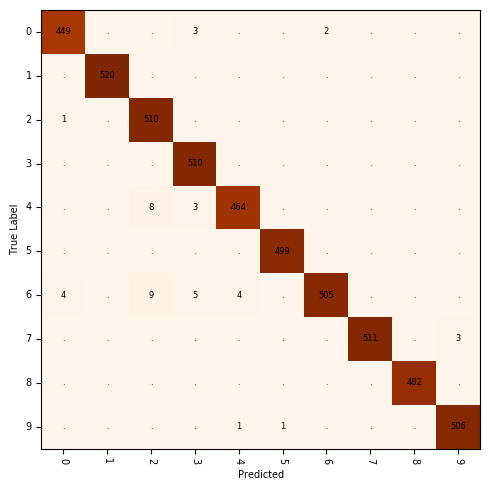

In [21]:
model = run(params)

In [36]:
# Continue training
model = CNN()
model.load_state_dict(torch.load('./tensorboard_logs/MNIST/saved_models/MNIST_LeNet_lr:0.001_Adam_NLLLoss_37520.pth'))

params = {
    'train_batch_size': 64,
    'val_batch_size': 64,
    'epochs': 40,
    'lr': 1e-3,
    'verbose': False,
    'tensorboard': True,
    'log_interval': 100,
    'log_dir': './tensorboard_logs',
    'model_name': 'LeNet',
    'model': model,
    'criterion': nn.NLLLoss(),
    'optimizer': optim.Adam,
    'early_stopping': True,
    'early_stopping_patience': 1,
    'lr_patience': 3,
    'lr_factor': 0.25,
    'min_lr': 1e-5,
}

model = run(params)

Final accuracy:  0.99
Confusion matrix:  tensor([[455,   0,   1,   0,   0,   0,  18,   0,   1,   0],
        [  0, 512,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 504,   0,   2,   0,   2,   0,   0,   0],
        [  5,   1,   2, 486,   1,   0,   1,   0,   0,   0],
        [  0,   0,   6,   0, 491,   0,   2,   0,   0,   0],
        [  0,   0,   0,   0,   0, 502,   0,   0,   0,   0],
        [  0,   0,   1,   0,   0,   0, 489,   0,   5,   0],
        [  0,   0,   0,   0,   0,   1,   0, 515,   0,   1],
        [  0,   0,   0,   0,   0,   0,   0,   0, 498,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 498]])
Precision:  tensor([0.9891, 0.9981, 0.9805, 1.0000, 0.9939, 0.9980, 0.9551, 1.0000, 0.9881,
        0.9980], dtype=torch.float64)
Recall:  tensor([0.9579, 1.0000, 0.9921, 0.9798, 0.9840, 1.0000, 0.9879, 0.9961, 1.0000,
        1.0000], dtype=torch.float64)
